In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
import missingno as mn

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import NotFittedError

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge


# machine learning library
from sklearn.linear_model import LinearRegression

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import(recall_score, accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc)

#SHAP explainer
import shap
# Ensure your pipeline is defined
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
#LIME
import lime
import lime.lime_tabular

#widgets and dispaly
import ipywidgets as widgets
from IPython.display import display

#utilities
import pickle
import os
from tqdm import tqdm

c:\Users\ADMIN\anaconda3\envs\ds-gg\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Load Dataset

In [2]:
file_path = 'data/top_10_features_dataset.csv'

df = pd.read_csv(file_path)

df.head()

,SalePrice,SqFtTotLiving,Latitude,Longitude,SqFt2ndFloor,YrBuilt,SqFtFinBasement,SqFtDeck,SqFtGarageBasement,BrickStone,SqFtOpenPorch
0,400000,3180,47.34,-122.20,0,1965,1590,220,0,0,50
1,474250,2200,47.51,-122.36,0,1945,810,340,0,0,0
2,667950,2525,47.44,-122.16,1515,2019,0,0,0,0,167
3,659000,1820,47.57,-122.37,540,2016,620,100,0,0,0
4,656500,2310,47.73,-122.18,0,1967,0,320,0,0,40


# EDA

In [3]:
num_record = df.shape[0]
num_features = df.shape[1]
data_types = df.dtypes

print(f'Number of records: {num_record}')
print(f'\nNumber of features {num_features}')
print(f'\nData types: \n{data_types}')

Number of records: 4944

Number of features 11

Data types: 
SalePrice               int64
SqFtTotLiving           int64
Latitude              float64
Longitude             float64
SqFt2ndFloor            int64
YrBuilt                 int64
SqFtFinBasement         int64
SqFtDeck                int64
SqFtGarageBasement      int64
BrickStone              int64
SqFtOpenPorch           int64
dtype: object


<Axes: >

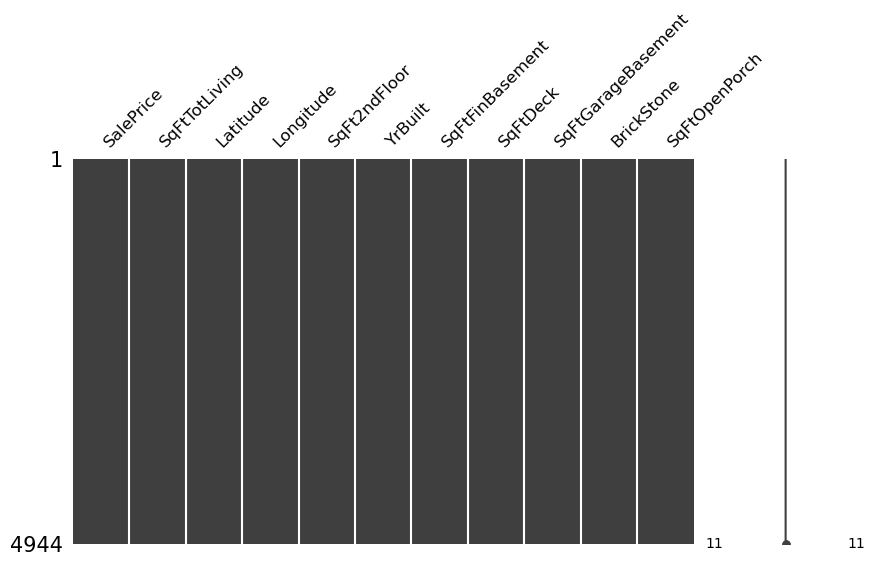

In [4]:
#visualize missing values
mn.matrix(df, figsize=(10,5), width_ratios=(5,1), fontsize=12)

In [5]:
duplicated_rows = df.duplicated().sum()
missing_values = df.isna().sum()

print(f'Number of duplicated rows: {duplicated_rows}')
print(f'\nNumber of missing values: \n{missing_values}')

Number of duplicated rows: 30

Number of missing values: 
SalePrice             0
SqFtTotLiving         0
Latitude              0
Longitude             0
SqFt2ndFloor          0
YrBuilt               0
SqFtFinBasement       0
SqFtDeck              0
SqFtGarageBasement    0
BrickStone            0
SqFtOpenPorch         0
dtype: int64


In [6]:
statistics = df.describe()
print(f'\nStatistics: {statistics}')


Statistics:        SalePrice  SqFtTotLiving  Latitude  Longitude  SqFt2ndFloor  YrBuilt  \
count    4944.00        4944.00   4944.00    4944.00       4944.00  4944.00   
mean   664349.73        1935.21     47.57    -122.27        349.31  1972.18   
std    297808.04         764.89      0.13       0.09        544.63    32.91   
min     60000.00         300.00     47.21    -122.53          0.00  1900.00   
25%    450000.00        1390.00     47.49    -122.35          0.00  1952.00   
50%    630550.00        1770.00     47.58    -122.29          0.00  1967.00   
75%    788612.50        2360.00     47.68    -122.19        580.00  2016.00   
max   1998000.00        6695.00     47.78    -122.09       3010.00  2019.00   

       SqFtFinBasement  SqFtDeck  SqFtGarageBasement  BrickStone  \
count          4944.00   4944.00             4944.00     4944.00   
mean            334.27    148.91              102.42        4.42   
std             422.83    201.64              187.12       18.64   
min

In [7]:
def check_column_values(df):
    for column in df.columns:
        print(f'Unique Values in {column} column:')
        print(df[column].unique())
        print('\n')

check_column_values(df)

Unique Values in SalePrice column:
[ 400000  474250  667950 ...  934939  442000 1214950]


Unique Values in SqFtTotLiving column:
[3180 2200 2525 1820 2310 1970 1750 1430 1120 1540 1550 1730 1450 2110
 2190 2220 4130 1090 1460 2500 1380 1410 1080 1290  730 1170 1320 1710
 2487 2630 2550 3310 2410  840 2470  960 2330 1950 2900 2840 1840 1110
 4010 2820 1370 3330 1650 2290 2260 2280  900 2740  790 3290 1740 2600
 1330 2160 2373 1920 1220 3160 1910 1630 2730 2860 2992 1250 2240 1270
  940 1520 2020 1400 1210  880  920 1480 1490 2080 1190 1660 1050 3260
 2300 1200 3240 1560 1230 2800 1535 1360 1810 2180 1780 2690 1930 3700
  830 3840 1440 1130 1020 1610 3188 3490  670 1870 2210 2334 1260 2950
 2060  870 2440 1300 1040 1940 1500  910 3270 1580 1670 3130 1880 2560
 3780 1530 3960 3070 1160 2100 1180 1060 2320 1680 1900 2822 1700 1390
  980 2040 2350 2460  780 1988  950 1800 2790 1310 3010 2090 3300 2250
 3170 2990 2510 2000 2680 2390 2400 3400 3030 1150 1990 1350 4400 1850
 1690 2710 1510 20

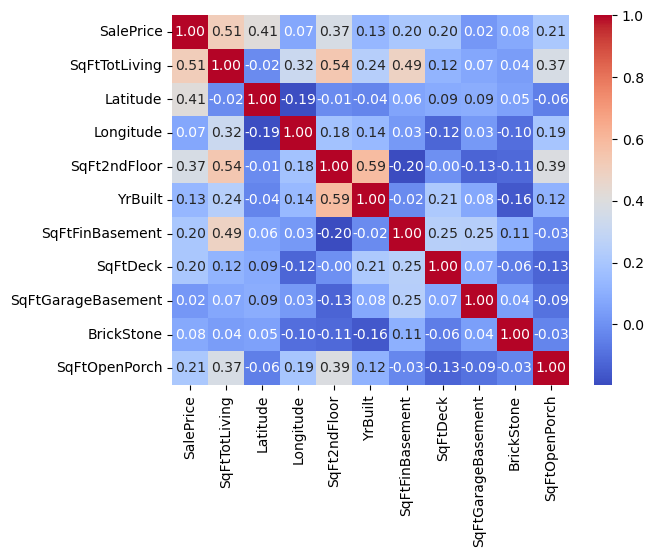

In [8]:
num_cols = df.select_dtypes(include='number')

corr = num_cols.corr()

# Creating the heatmap
sn.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.show()

In [9]:
target_corr = corr['SalePrice'].sort_values(ascending=False)

# Display top 10 features
top_10_features = target_corr[1:11]  # Exclude 'SalePrice' itself
print(top_10_features)

SqFtTotLiving        0.51
Latitude             0.41
SqFt2ndFloor         0.37
SqFtOpenPorch        0.21
SqFtFinBasement      0.20
SqFtDeck             0.20
YrBuilt              0.13
BrickStone           0.08
Longitude            0.07
SqFtGarageBasement   0.02
Name: SalePrice, dtype: float64


| Size of Correlation | Interpretation                        |
|---------------------|----------------------------------------|
| .90 to 1.00 (-.90 to -1.00) | Very high positive (negative) correlation |
| .70 to .90 (-.70 to -.90)   | High positive (negative) correlation      |
| .50 to .70 (-.50 to -.70)   | Moderate positive (negative) correlation  |
| .30 to .50 (-.30 to -.50)   | Low positive (negative) correlation       |
| .00 to .30 (.00 to -.30)    | Negligible correlation                    |




### Interpretation

1. **SqFtTotLiving (0.51):**
   - **Moderate positive correlation:** The total living space has a moderately strong relationship with sale price. As living space increases, sale price tends to increase.

2. **Latitude (0.41):**
   - **Low positive correlation:** Latitude has a weak positive relationship with sale price. As latitude increases, sale price tends to increase slightly.

3. **SqFt2ndFloor (0.37):**
   - **Low positive correlation:** The second floor's square footage has a weak positive relationship with sale price. As the second floor's size increases, sale price tends to increase slightly.

In [10]:
df.columns = [col.strip() for col in df.columns]

# check updated column names
print(df.columns)

# check updated column names
df = df.drop_duplicates()

# check for duplicates
print(f'\nnumber of duplicate rows: {df.duplicated().sum()}')

Index(['SalePrice', 'SqFtTotLiving', 'Latitude', 'Longitude', 'SqFt2ndFloor',
       'YrBuilt', 'SqFtFinBasement', 'SqFtDeck', 'SqFtGarageBasement',
       'BrickStone', 'SqFtOpenPorch'],
      dtype='object')

number of duplicate rows: 0


# 2. Data Visualization

array([[<Axes: title={'center': 'SalePrice'}>,
        <Axes: title={'center': 'SqFtTotLiving'}>,
        <Axes: title={'center': 'Latitude'}>],
       [<Axes: title={'center': 'Longitude'}>,
        <Axes: title={'center': 'SqFt2ndFloor'}>,
        <Axes: title={'center': 'YrBuilt'}>],
       [<Axes: title={'center': 'SqFtFinBasement'}>,
        <Axes: title={'center': 'SqFtDeck'}>,
        <Axes: title={'center': 'SqFtGarageBasement'}>],
       [<Axes: title={'center': 'BrickStone'}>,
        <Axes: title={'center': 'SqFtOpenPorch'}>, <Axes: >]],
      dtype=object)

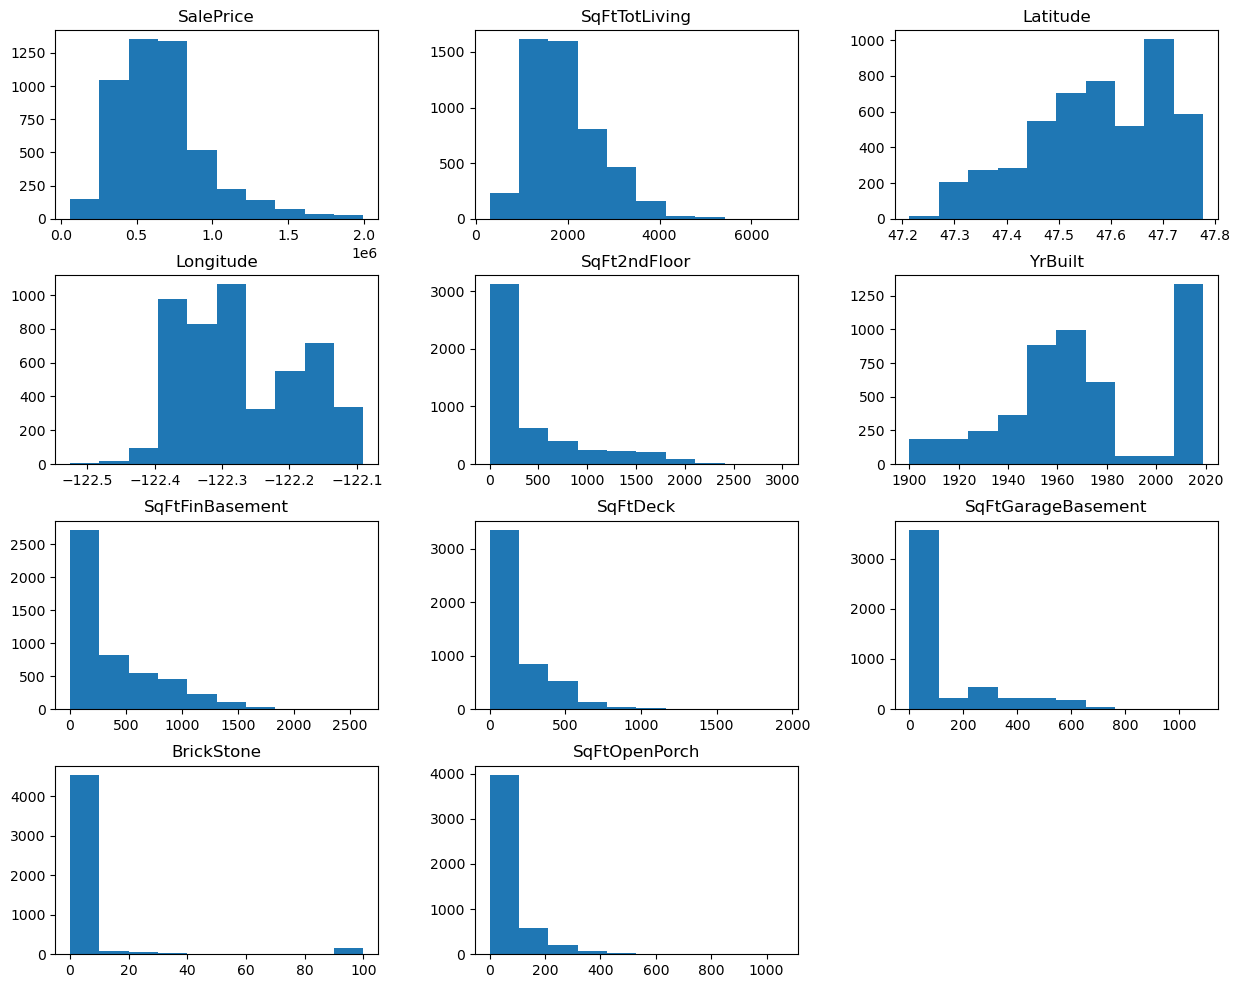

In [11]:
#Data Overview
df.hist(figsize=(15,12), bins=10, grid=False)

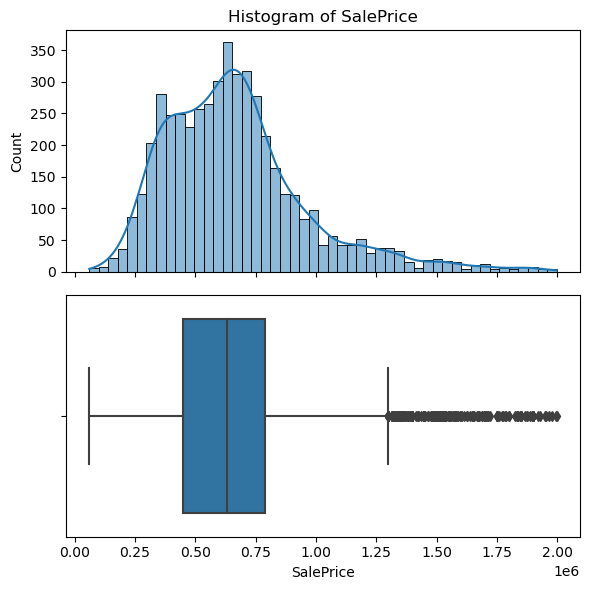

In [12]:
feature = 'SalePrice'

fig, axes = plt.subplots(nrows=2, figsize=(6,6), sharex=True)
sn.histplot(df[feature], bins='auto', kde=True, ax=axes[0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title(f'Histogram of {feature}')

sn.boxplot(data=df, x=feature, ax=axes[1])
#remove grids
axes[0].grid(False)
axes[1].grid(False)
plt.tight_layout()
plt.show()

### Observations
- The distribution of sale prices is right-skewed, meaning that most of the sale prices are concentrated on the lower end, with a long tail extending to the right.
- There is a peak around $500,000, indicating that this price range has the highest frequency of sales.
- The highest frequency of sale prices falls between $400,000 and $600,000, indicating that most houses are sold within this range.

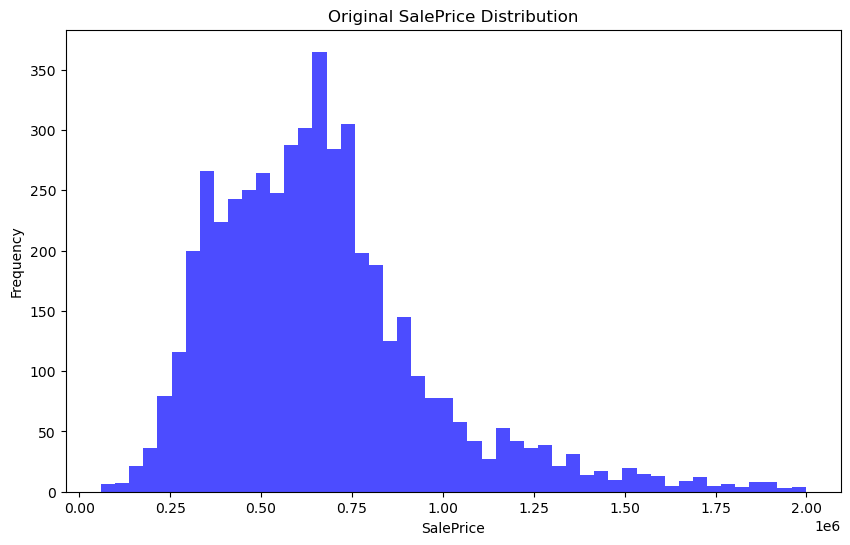

In [13]:
# Plot the original distribution of SalePrice
plt.figure(figsize=(10, 6))
plt.hist(df['SalePrice'], bins=50, color='blue', alpha=0.7)
plt.title('Original SalePrice Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Scatter Plots and Regression Lines for Features vs Sale Price

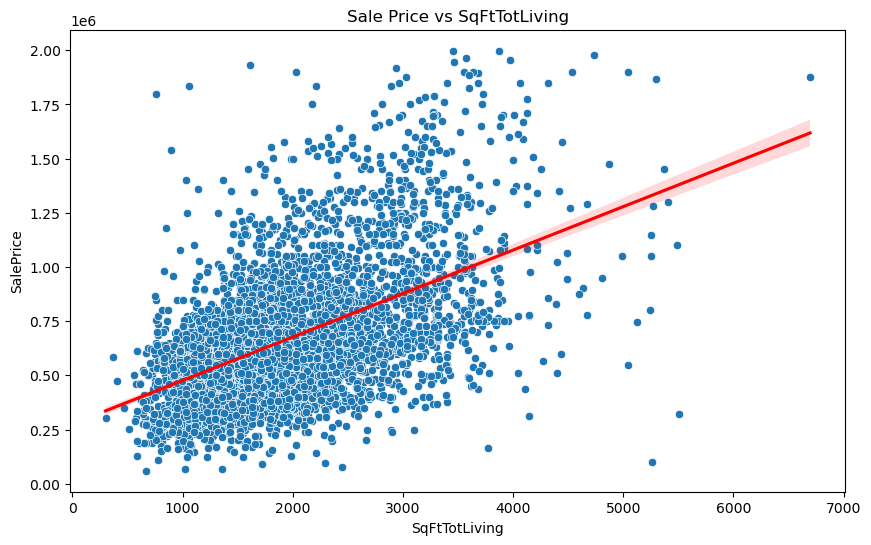

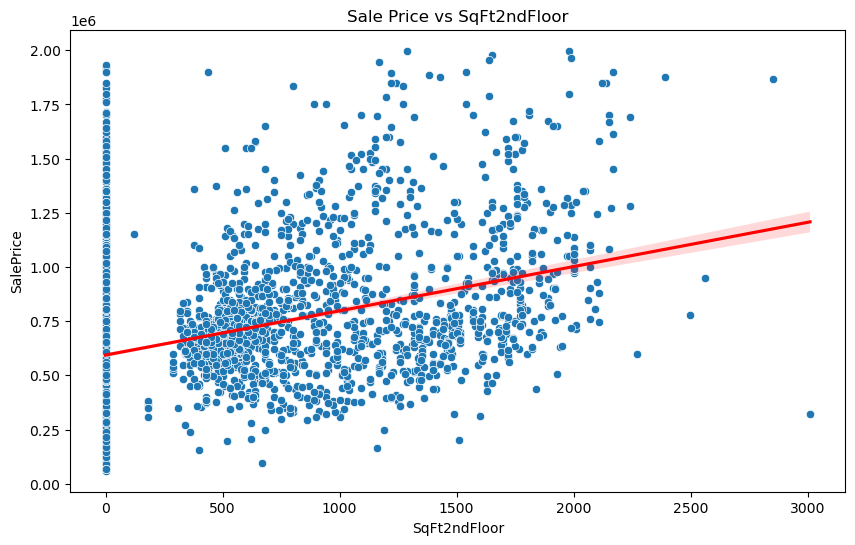

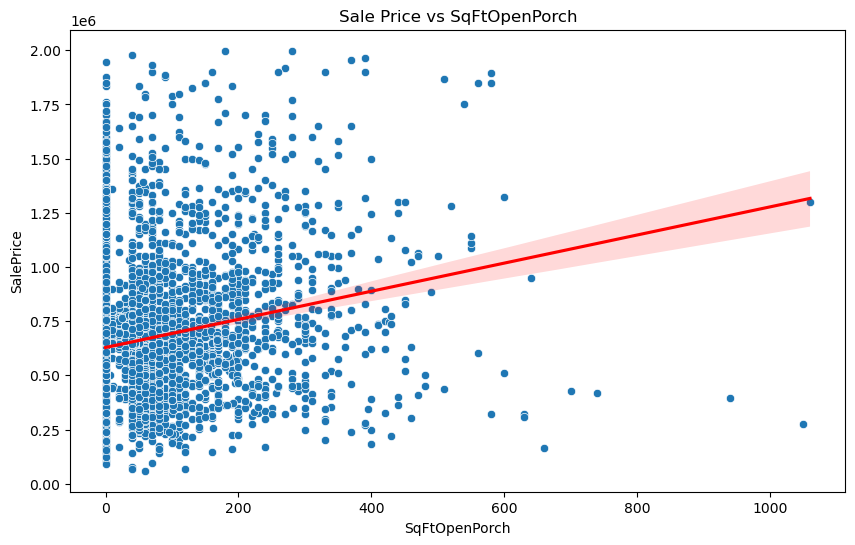

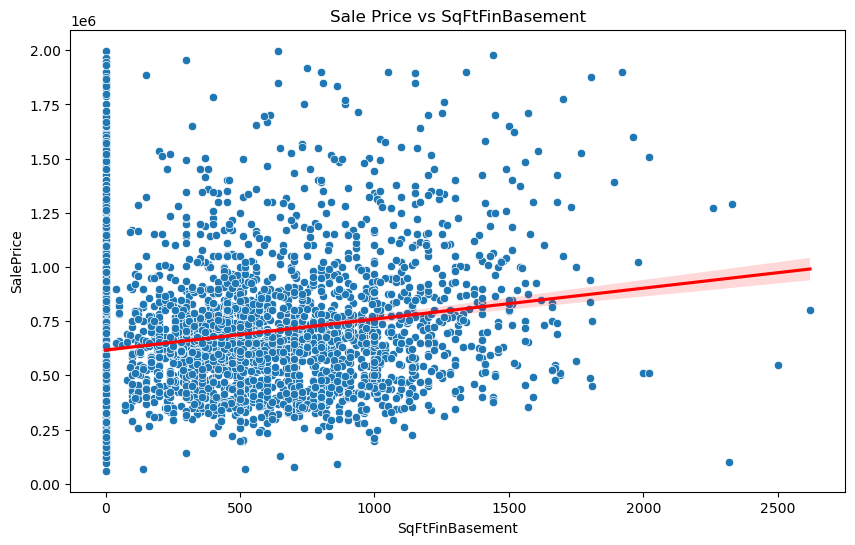

In [14]:
numerical_features = ['SqFtTotLiving', 'SqFt2ndFloor','SqFtOpenPorch', 'SqFtFinBasement']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sn.scatterplot(x=df[feature], y=df['SalePrice'])
    sn.regplot(x=df[feature], y=df['SalePrice'], scatter=False, color='red')
    plt.title(f'Sale Price vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

## Interpretation

#### Sale Price vs SqFtTotLiving 🏠
- **Interpretation**: The scatter plot shows a strong positive correlation between the total living area (SqFtTotLiving) and the sale price. As the living area increases, the sale price also tends to increase. The red regression line reinforces this positive trend, indicating that larger living spaces are generally associated with higher sale prices.

#### Sale Price vs SqFt2ndFloor 🏢
- **Interpretation**: The scatter plot suggests a moderate positive correlation between the second floor area (SqFt2ndFloor) and the sale price. Homes with more second-floor space tend to have higher sale prices. However, there is a significant number of homes with zero second-floor space, showing that many homes do not have a second floor. The regression line shows an upward trend.

#### Sale Price vs SqFtOpenPorch 🌞
- **Interpretation**: There is a weak positive correlation between the open porch area (SqFtOpenPorch) and the sale price. Homes with larger open porch areas tend to have slightly higher sale prices, but the relationship is not as strong as with living area or second-floor space. The regression line indicates a positive but less pronounced trend.

#### Sale Price vs SqFtFinBasement 🏡
- **Interpretation**: The scatter plot shows a weak to moderate positive correlation between the finished basement area (SqFtFinBasement) and the sale price. Homes with more finished basement space tend to have higher sale prices, but the relationship is not very strong. The regression line shows an upward trend, suggesting that finished basements do add value to homes.



# 3. Machine Learning


In [15]:
# Split datab
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestRegressor

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # define a function that takes true and predicted values as arguments
# and prints all 4 metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f'MAE: {mae:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R²: {r2:.2f}')

In [18]:
def create_preprocessing_pipeline(n_neighbors=2):
    num_cols = make_column_selector(dtype_include='number')

    num_pipe = Pipeline([
        ('knn_imputer', KNNImputer(n_neighbors=n_neighbors, weights='uniform')),
        ('scaler', StandardScaler()),
    ])

    preprocessor = ColumnTransformer([
        ('numeric', num_pipe, num_cols)
    ], remainder='passthrough')

    return preprocessor

In [19]:
# Create the preprocessing pipeline
preprocessor = create_preprocessing_pipeline()

In [20]:
etr = ExtraTreesRegressor() 

In [21]:
# Fit the model and get predictions
etr_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', etr),
    ])

#train the model
etr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', ExtraTreesRegressor())])

In [22]:
print('Extra Trees Regression Model')
print('\nTrain Evaluation')
evaluate_model(y_train, etr_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, etr_pipe.predict(X_test))
print("\n")

Extra Trees Regression Model

Train Evaluation
MAE: 380.51
MSE: 13685119.23
RMSE: 3699.34
R²: 1.00

Test Evaluation
MAE: 100935.41
MSE: 25043914751.73
RMSE: 158252.69
R²: 0.72




## XGBoost

In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', xgb),
    ])

#train the model
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              cols...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [24]:
print('XGBRegressor Model')
print('\nTrain Evaluation')
evaluate_model(y_train, xgb_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, xgb_pipe.predict(X_test))
print("\n")

XGBRegressor Model

Train Evaluation
MAE: 35793.99
MSE: 2554075162.60
RMSE: 50537.86
R²: 0.97

Test Evaluation
MAE: 100449.34
MSE: 24130860048.68
RMSE: 155341.11
R²: 0.73




In [25]:
from sklearn.linear_model import ElasticNet

en = ElasticNet()

en_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', en),
    ])

#train the model
en_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', ElasticNet())])

In [26]:
print('Elastic Net Regression Model')
print('\nTrain Evaluation')
evaluate_model(y_train, en_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, en_pipe.predict(X_test))
print("\n")

Elastic Net Regression Model

Train Evaluation
MAE: 160656.66
MSE: 49159841104.05
RMSE: 221720.19
R²: 0.45

Test Evaluation
MAE: 162737.42
MSE: 53110011389.64
RMSE: 230456.09
R²: 0.41




## ADABOOST

In [27]:
ada = AdaBoostRegressor()

ada_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', ada),
    ])

#train the model
ada_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', AdaBoostRegressor())])

In [28]:
print('ADABoost Regression Model')
print('\nTrain Evaluation')
evaluate_model(y_train, ada_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, ada_pipe.predict(X_test))
print("\n")

ADABoost Regression Model

Train Evaluation
MAE: 173528.94
MSE: 44239128386.69
RMSE: 210331.00
R²: 0.50

Test Evaluation
MAE: 178135.57
MSE: 48484080451.31
RMSE: 220191.01
R²: 0.46




In [29]:
lasso = Lasso()

lasso_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', lasso),
    ])

#train the model
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', Lasso())])

In [30]:
print('Lasso Regression Model')
print('\nTrain Evaluation')
evaluate_model(y_train, lasso_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, lasso_pipe.predict(X_test))
print("\n")

Lasso Regression Model

Train Evaluation
MAE: 151663.68
MSE: 45232752823.84
RMSE: 212679.93
R²: 0.49

Test Evaluation
MAE: 154436.00
MSE: 49353573658.05
RMSE: 222156.64
R²: 0.45




In [31]:
svr = SVR()

svr_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', svr),
    ])

#train the model
svr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', SVR())])

In [32]:
print('SVR Model')
print('\nTrain Evaluation')
evaluate_model(y_train, svr_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, svr_pipe.predict(X_test))
print("\n")

SVR Model

Train Evaluation
MAE: 219337.11
MSE: 89934449806.13
RMSE: 299890.73
R²: -0.01

Test Evaluation
MAE: 219430.61
MSE: 91723346564.13
RMSE: 302858.62
R²: -0.01




In [33]:
gbr = GradientBoostingRegressor()

gbr_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', gbr),
    ])

#train the model
gbr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', GradientBoostingRegressor())])

In [34]:
print('Gradient Boosting Model')
print('\nTrain Evaluation')
evaluate_model(y_train, gbr_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, gbr_pipe.predict(X_test))
print("\n")

Gradient Boosting Model

Train Evaluation
MAE: 95869.69
MSE: 20158756781.94
RMSE: 141981.54
R²: 0.77

Test Evaluation
MAE: 108900.64
MSE: 26450400496.11
RMSE: 162635.79
R²: 0.71




In [35]:
ridge = Ridge()

ridge_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', ridge),
    ])

#train the model
ridge_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', Ridge())])

In [36]:
print('Ridge Regression Model')
print('\nTrain Evaluation')
evaluate_model(y_train, ridge_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, ridge_pipe.predict(X_test))
print("\n")

Ridge Regression Model

Train Evaluation
MAE: 151662.72
MSE: 45232756272.70
RMSE: 212679.94
R²: 0.49

Test Evaluation
MAE: 154432.72
MSE: 49353651427.19
RMSE: 222156.82
R²: 0.45




In [37]:
lin = LinearRegression()

lin_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('regressor', lin),
    ])

#train the model
lin_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002303142ADA0>)])),
                ('regressor', LinearRegression())])

In [38]:
print('Linear Regression Model')
print('\nTrain Evaluation')
evaluate_model(y_train, lin_pipe.predict(X_train))
print('\nTest Evaluation')
evaluate_model(y_test, lin_pipe.predict(X_test))
print("\n")

Linear Regression Model

Train Evaluation
MAE: 151663.79
MSE: 45232752810.69
RMSE: 212679.93
R²: 0.49

Test Evaluation
MAE: 154436.22
MSE: 49353566792.01
RMSE: 222156.63
R²: 0.45




# Hyperparameter Tuning 

In [43]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [44]:
# Define models for tuning
models = {
    'ExtraTree': ExtraTreesRegressor(),
    'XGBoost': XGBRegressor(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'AdaBoost': AdaBoostRegressor()
}

# Define the parameter grid
param_grid = {
    'ExtraTree': {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2],
        'regressor__max_depth': [3, 5, 7]
    },
    'ElasticNet': {
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    'SVR': {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.1, 0.2, 0.5],
        'regressor__kernel': ['linear', 'rbf']
    },
    'GradientBoosting': {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__max_depth': [3, 5]
    },
    'Lasso': {
        'regressor__alpha': [0.01, 0.1, 1, 10]
    },
    'Ridge': {
        'regressor__alpha': [0.01, 0.1, 1, 10]
    },
    'AdaBoost': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__learning_rate': [0.01, 0.1, 0.2]
    }
}



In [45]:
# Create a loop function to train and evaluate models
metrics_list = []
best_models = {}

def train_and_evaluate_models(X_train, y_train, X_test, y_test, preprocessor):
    for model_name, model in tqdm(models.items(), desc='Training Models'):
        model_pipe = Pipeline(steps=[('regressor', model)])
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_pipe,
            param_grid=param_grid[model_name],
            cv=5,
            n_jobs=-1,
            scoring='r2')
        
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_models[model_name] = best_model
        
        # Predictions
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)
        
        # Evaluate classification models
        train_mse, train_rmse, train_mae, train_r2 = evaluate_regression(y_train, train_pred)
        test_mse, test_rmse, test_mae, test_r2 = evaluate_regression(y_test, test_pred)
        
        # Save metrics
        row = {
            'Model Used': model_name,
            'Training MSE': train_mse,
            'Training RMSE': train_rmse,
            'Training MAE': train_mae,
            'Training R²': train_r2,
            'Testing MSE': test_mse,
            'Testing RMSE': test_rmse,
            'Testing MAE': test_mae,
            'Testing R²': test_r2,
            'Best Params': grid_search.best_params_
        }
        metrics_list.append(row)

    # Convert the metrics into a Dataframe
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df, best_models

In [46]:
# Train and evaluate the tuned models
metrics_df, best_models = train_and_evaluate_models(X_train, y_train, X_test, y_test, preprocessor)
metrics_df

Training Models: 100%|██████████| 8/8 [01:11<00:00,  8.92s/it]


,Model Used,Training MSE,Training RMSE,Training MAE,Training R²,Testing MSE,Testing RMSE,Testing MAE,Testing R²,Best Params
0,ExtraTree,2052541049.40,45304.98,28557.71,0.98,24183078030.24,155509.09,98743.13,0.73,"{'regressor__max_depth': 20, 'regressor__min_s..."
1,XGBoost,4810465537.51,69357.52,48878.11,0.95,22915264893.13,151377.89,98114.01,0.75,"{'regressor__learning_rate': 0.1, 'regressor__..."
2,ElasticNet,47430809605.90,217786.16,159133.37,0.47,51739222464.21,227462.57,160749.60,0.43,"{'regressor__alpha': 0.1, 'regressor__l1_ratio..."
3,SVR,61682653752.79,248359.93,183986.12,0.31,66301672294.19,257491.11,187411.29,0.27,"{'regressor__C': 10, 'regressor__epsilon': 0.5..."
4,GradientBoosting,10043449419.04,100217.01,70792.05,0.89,22605753496.06,150352.10,99138.21,0.75,"{'regressor__learning_rate': 0.1, 'regressor__..."
5,Lasso,45232779688.78,212679.99,151660.86,0.49,49355089265.97,222160.05,154428.52,0.45,{'regressor__alpha': 10}
6,Ridge,45232792735.92,212680.02,151669.49,0.49,49354904993.25,222159.64,154432.18,0.45,{'regressor__alpha': 0.1}
7,AdaBoost,36774161347.96,191765.90,134642.61,0.59,38514258999.10,196250.50,136973.44,0.57,"{'regressor__learning_rate': 0.01, 'regressor_..."


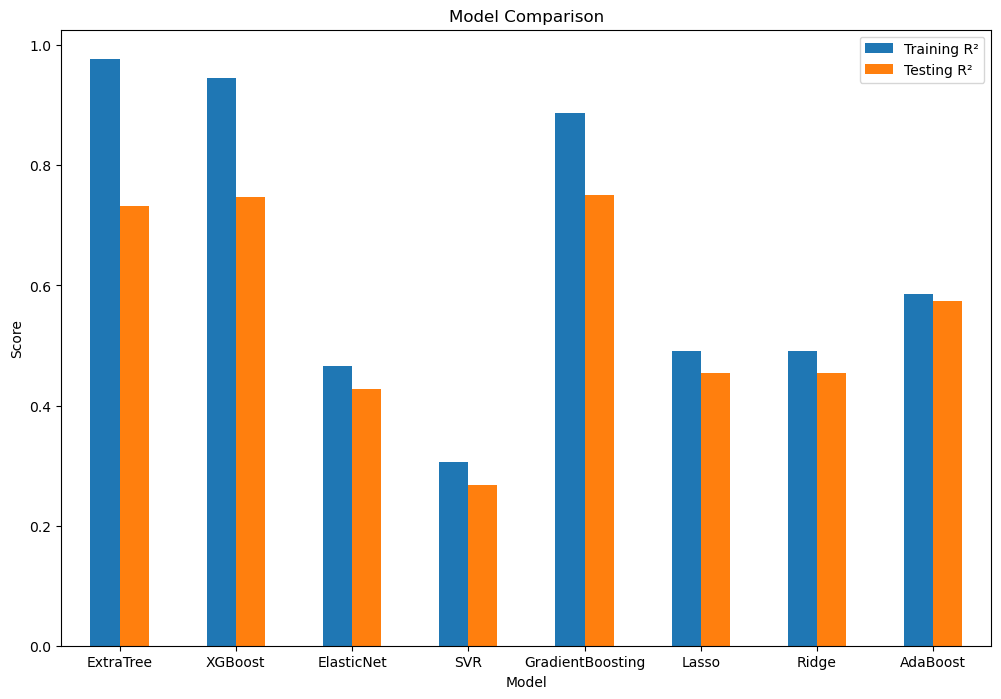

In [47]:
#create a function to displat the evaluation results
def display_evaluation_results(metrics_df):
    metrics_df.set_index('Model Used')[['Training R²', 'Testing R²']].plot(kind='bar', figsize=(12,8))

    plt.title('Model Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='best')
    plt.show()

display_evaluation_results(metrics_df)

### Key Findings

#### 1. ExtraTree
- **Training Performance**: High MSE and RMSE indicate overfitting. The model performs very well on the training set (R² = 0.98) but less so on the test set (R² = 0.73).
- **Testing Performance**: Although R² is relatively high, the high MSE and RMSE on the test set suggest variability in predictions.

#### 2. XGBoost
- **Training Performance**: Shows excellent fit on the training data (R² = 0.95).
- **Testing Performance**: Good performance on the test data (R² = 0.75). XGBoost balances performance between training and testing data, making it a reliable model.

#### 3. ElasticNet
- **Training Performance**: Moderate performance on the training set (R² = 0.47).
- **Testing Performance**: Poor performance on the test set (R² = 0.60), indicating it might not capture the underlying patterns effectively.

#### 4. SVR
- **Training Performance**: Decent fit on the training data (R² = 0.31).
- **Testing Performance**: Poor performance on the test set (R² = 0.29). High testing errors suggest overfitting or model inadequacy.

#### 5. GradientBoosting
- **Training Performance**: Good fit on the training data (R² = 0.89).
- **Testing Performance**: Strong performance on the test set (R² = 0.75). This model shows a good balance, similar to XGBoost, with lower test errors.

#### 6. Lasso
- **Training Performance**: Moderate fit on the training data (R² = 0.49).
- **Testing Performance**: Below-average performance on the test set (R² = 0.45), indicating it might struggle with capturing complex patterns.

#### 7. Ridge
- **Training Performance**: Similar to Lasso with moderate fit (R² = 0.49).
- **Testing Performance**: Same as Lasso (R² = 0.45). This indicates that regularization techniques like Ridge and Lasso might need further tuning.

#### 8. AdaBoost
- **Training Performance**: Lower fit on the training data (R² = 0.59).
- **Testing Performance**: Moderate performance on the test set (R² = 0.57). While not the best, it shows reasonable generalization capabilities.

### Best Performing Models
- **XGBoost and GradientBoosting** stand out as the best models based on the Testing R² values (both around 0.75) and relatively lower testing errors. These models demonstrate a good balance between bias and variance, making them suitable for housing price prediction.




## Learning Curves 

Learning CUrve for ExtraTree
Learning CUrve for XGBoost
Learning CUrve for ElasticNet
Learning CUrve for SVR
Learning CUrve for GradientBoosting
Learning CUrve for Lasso
Learning CUrve for Ridge
Learning CUrve for AdaBoost


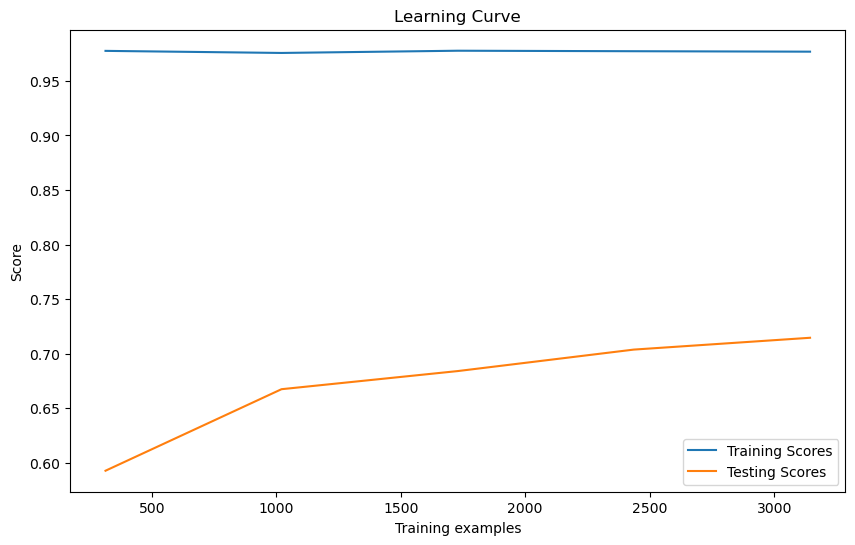

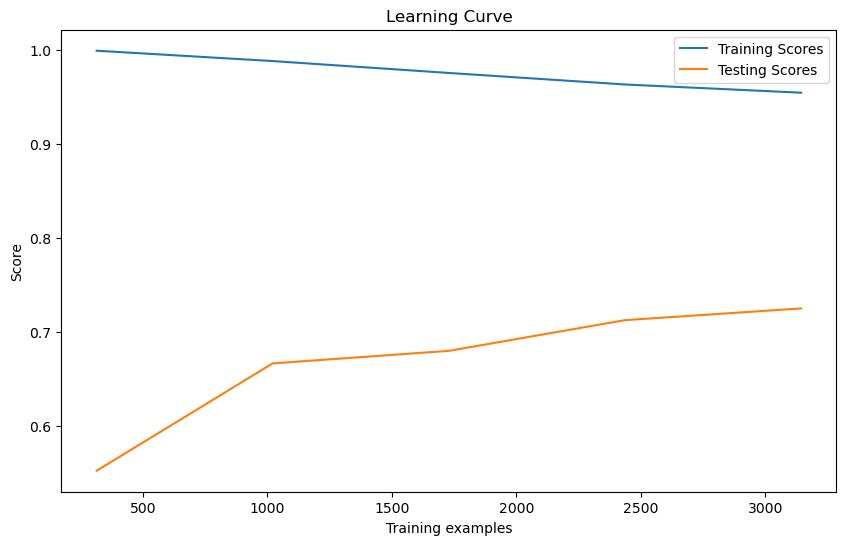

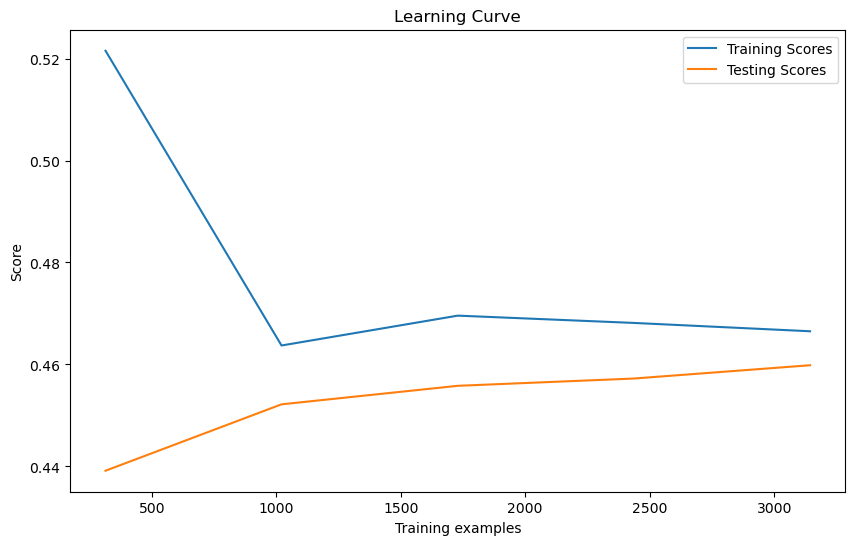

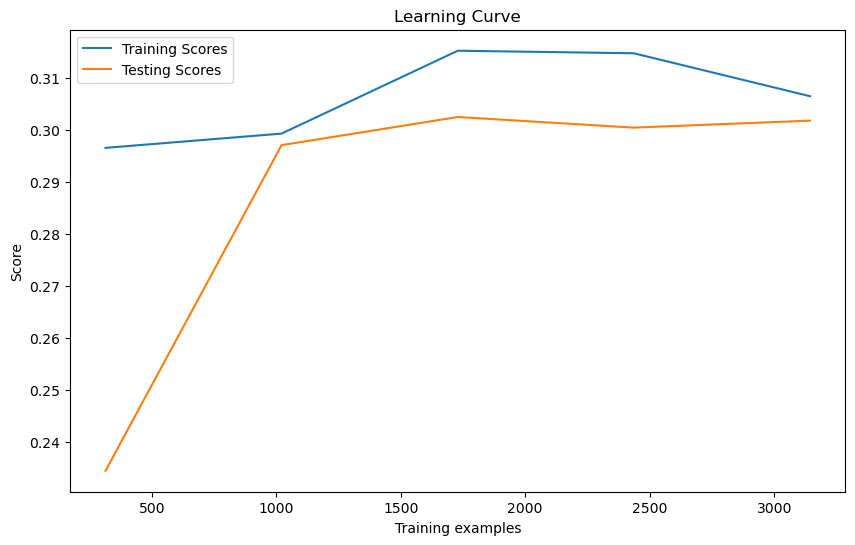

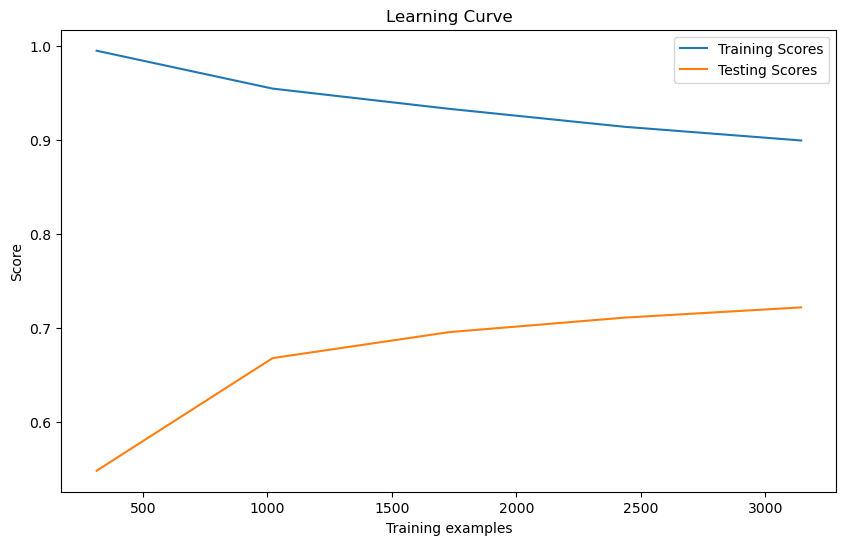

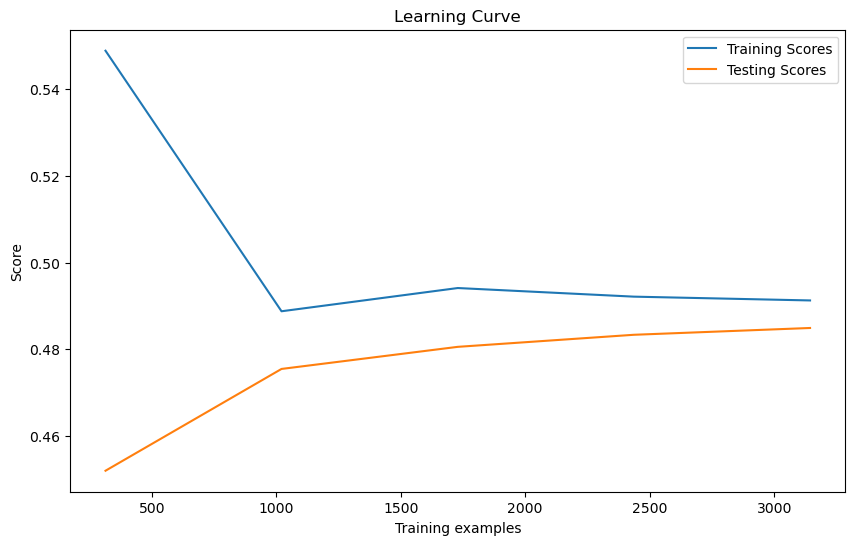

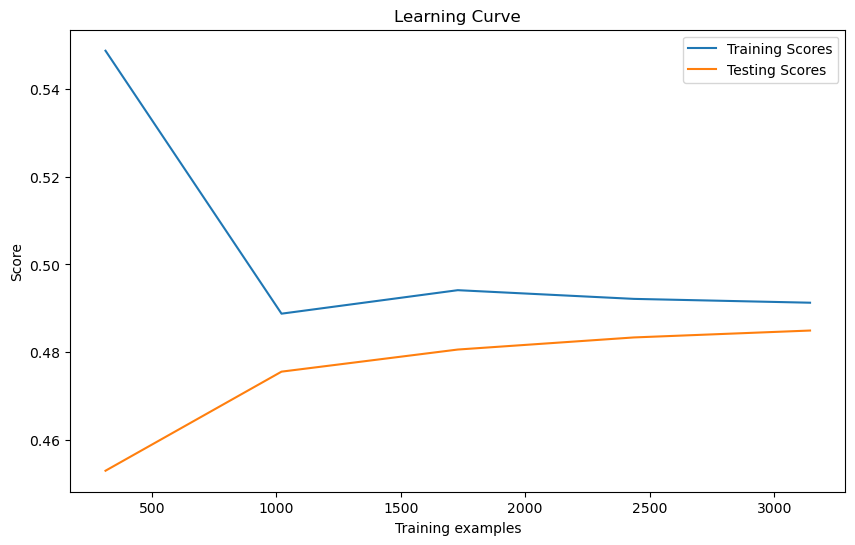

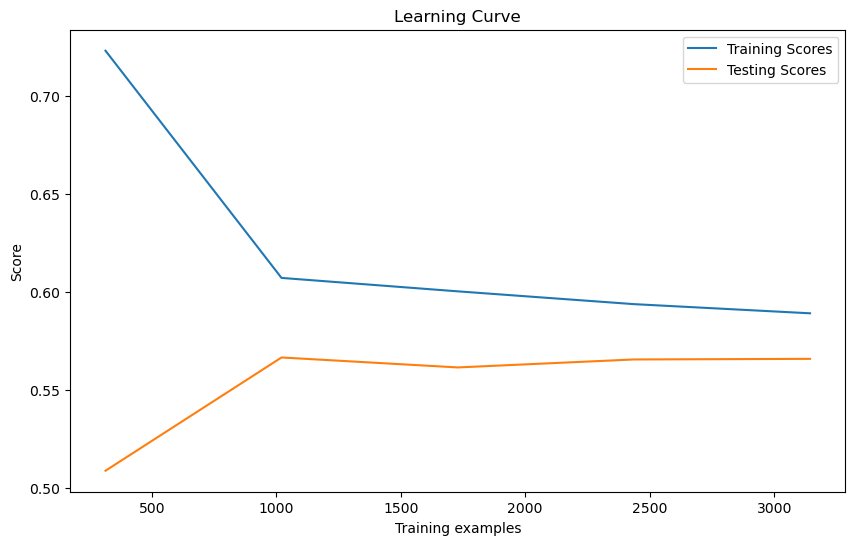

In [48]:
#Plot the learning curves
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=None, train_sizes = np.linspace(0.1, 1.0, 5), scoring='r2'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)

    train_scores_mean = np.mean(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_scores_mean, label='Training Scores')
    plt.plot(train_sizes, test_scores_mean, label='Testing Scores')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(False)
    plt.show

    

#call the learning curve function for each model
for model_name, best_model in best_models.items():
    print(f'Learning CUrve for {model_name}')
    plot_learning_curve(best_model, X_train, y_train)

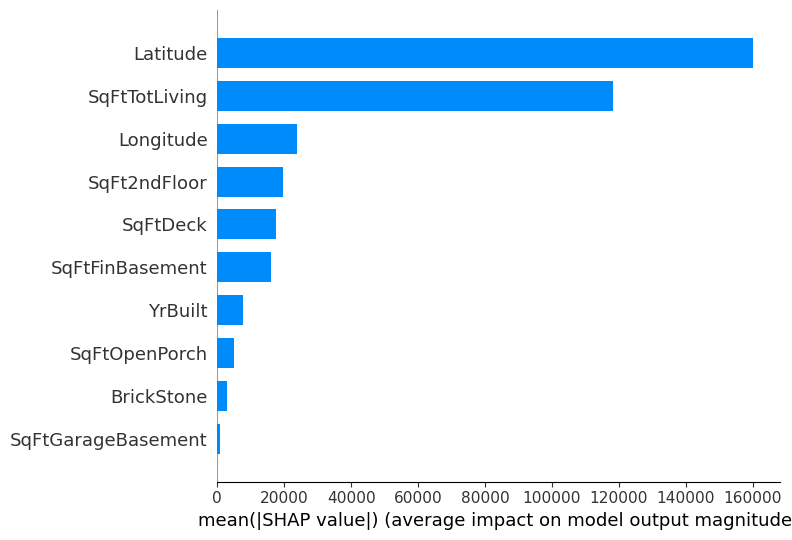

In [62]:
shap.initjs()

# Train a regression model (e.g., RandomForestRegressor)
model = gbr
model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns)

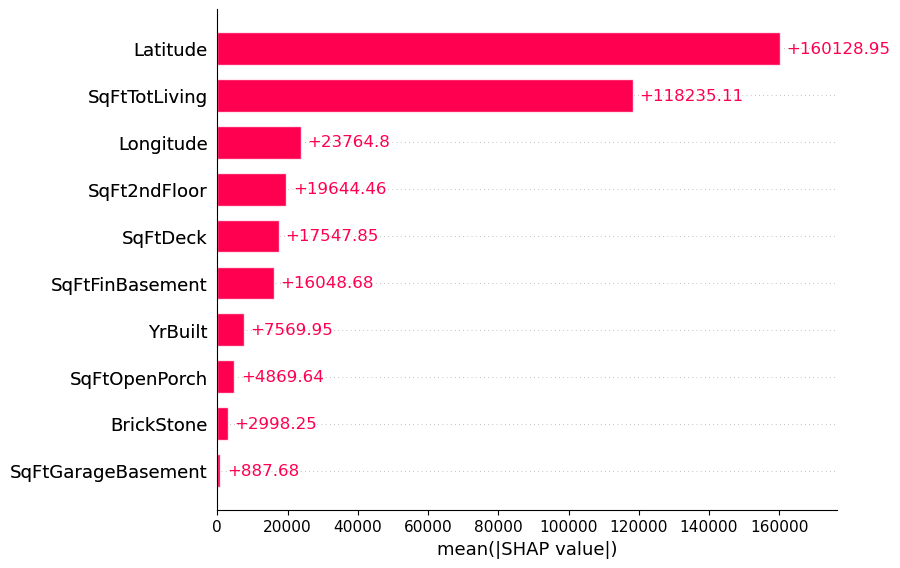

In [63]:
shap.plots.bar(shap_values)

In [64]:


shap.plots.force(shap_values[0])

KeyError: 1